In [1]:
# Helper functions
from notebooks.util.distribution_utils import *

from liquidity.util.utils import get_agg_features
from hurst_exponent.util.utils import augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [16]:
# Number of events to use
EVENTS_RANGE = 1000000

# Bin/window size for computing events
T = 100


## Load raw sample data

In [6]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

## 1. Orderflow

### 1.1. Volume/Size

In [7]:
# Order size/ volume
size_volume = {'TSLA': tsla_raw_df['norm_trade_volume'],
               'MSFT': amzn_raw_df['norm_trade_volume'],
               'AMZN': nflx_raw_df['norm_trade_volume'],
               'NFLX': msft_raw_df['norm_trade_volume'],
               'EBAY': ebay_raw_df['norm_trade_volume'],
               'APPL': appl_raw_df['norm_trade_volume'],
               }
size_volume = {stock: data.head(EVENTS_RANGE) for stock, data in size_volume.items()}

#### Stationarity Test

In [6]:
# ADF test
for stock, data in size_volume.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -57.24
p-value: 0.00,
N: 99977, 
critical values: {'1%': -3.430415409723302, '5%': -2.8615689100728545, '10%': -2.5667853878201634}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -57.24
p-value: 0.00,
N: 99977, 
critical values: {'1%': -3.430415409723302, '5%': -2.8615689100728545, '10%': -2.5667853878201634}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -57.24
p-value: 0.00,
N: 99977, 
critical values: {'1%': -3.430415409723302, '5%': -2.8615689100728545, '10%': -2.5667853878201634}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -57.24
p-value: 0.00,
N: 99977, 
critical values: {'1%': -3.430415409723302, '5%': -2.8615689100728545, '10%': -2.5667853878201634}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EBAY

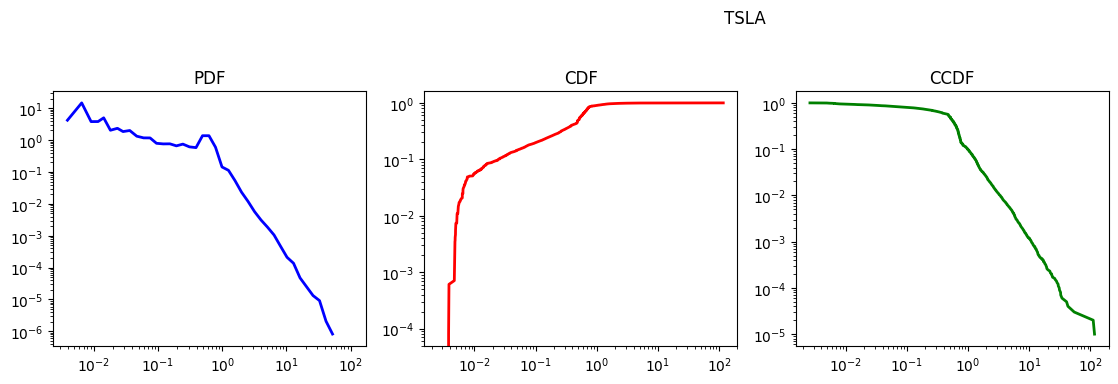

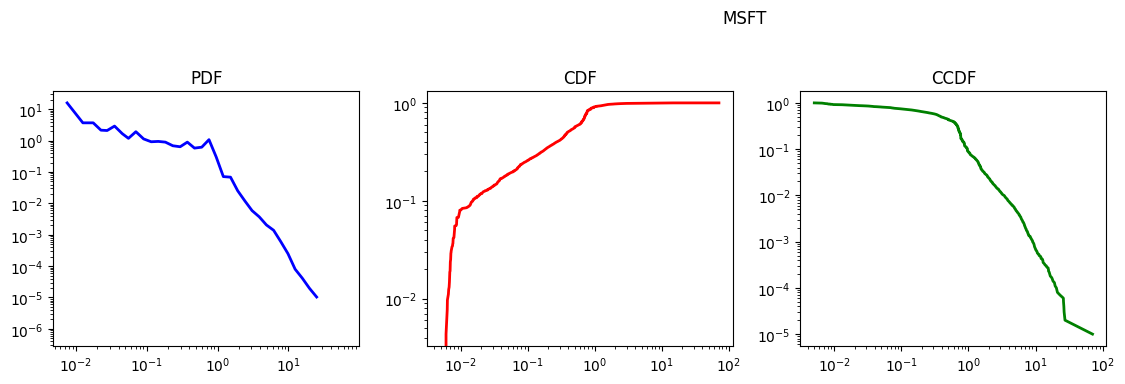

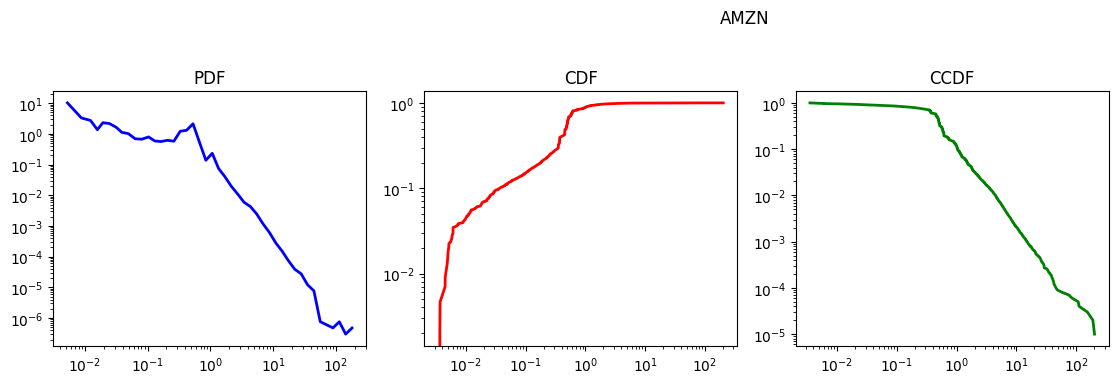

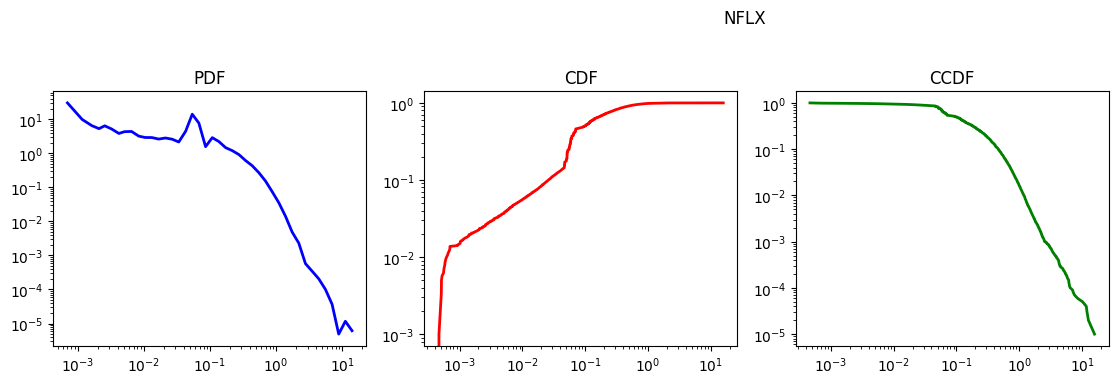

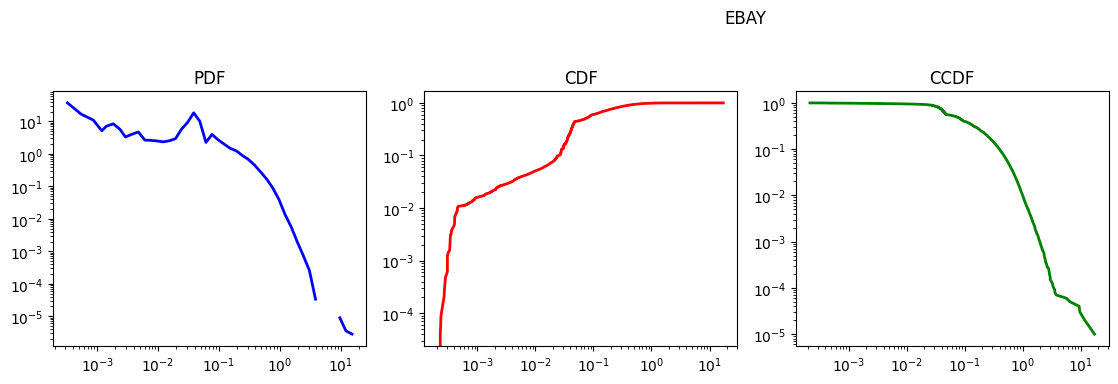

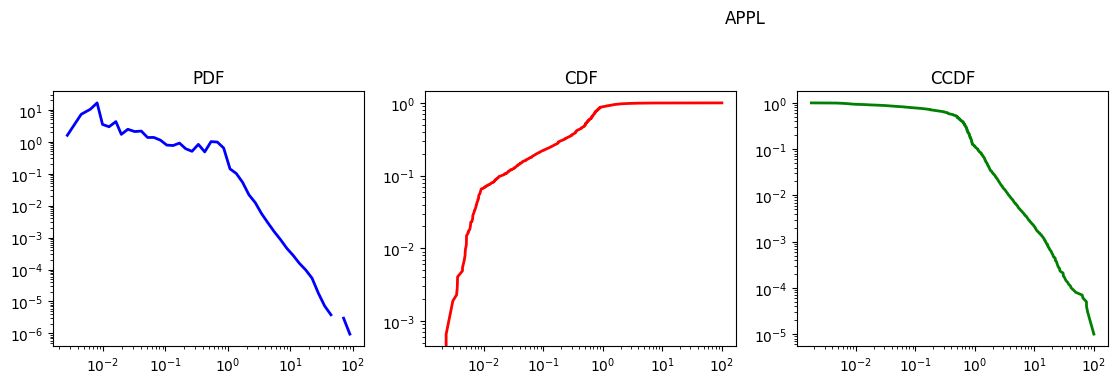

In [17]:
# Plot distribution of size_volume for each stock
for stock_name, data in size_volume.items():
    plot_distributions(stock_name, data)

### 1.2. Fit power law distribution

In [22]:
# 1. Fit Powerlaw and retrieve fitted object/ results
size_volume_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_size_volume_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(size_volume_data):
    volume_fit_objects = fit_powerlaw(size_volume, filename=size_volume_data)
else:
    volume_fit_objects = load_fit_objects(size_volume_data)

volume_fit_objects

{'TSLA': <powerlaw.Fit at 0x1514a0e50>,
 'MSFT': <powerlaw.Fit at 0x168bba8d0>,
 'AMZN': <powerlaw.Fit at 0x157c8c290>,
 'NFLX': <powerlaw.Fit at 0x151d27f10>,
 'EBAY': <powerlaw.Fit at 0x168c0e850>,
 'APPL': <powerlaw.Fit at 0x151d87850>}

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1507: RuntimeWarning: overflow encountered in divide
  likelihoods = f/C
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overf

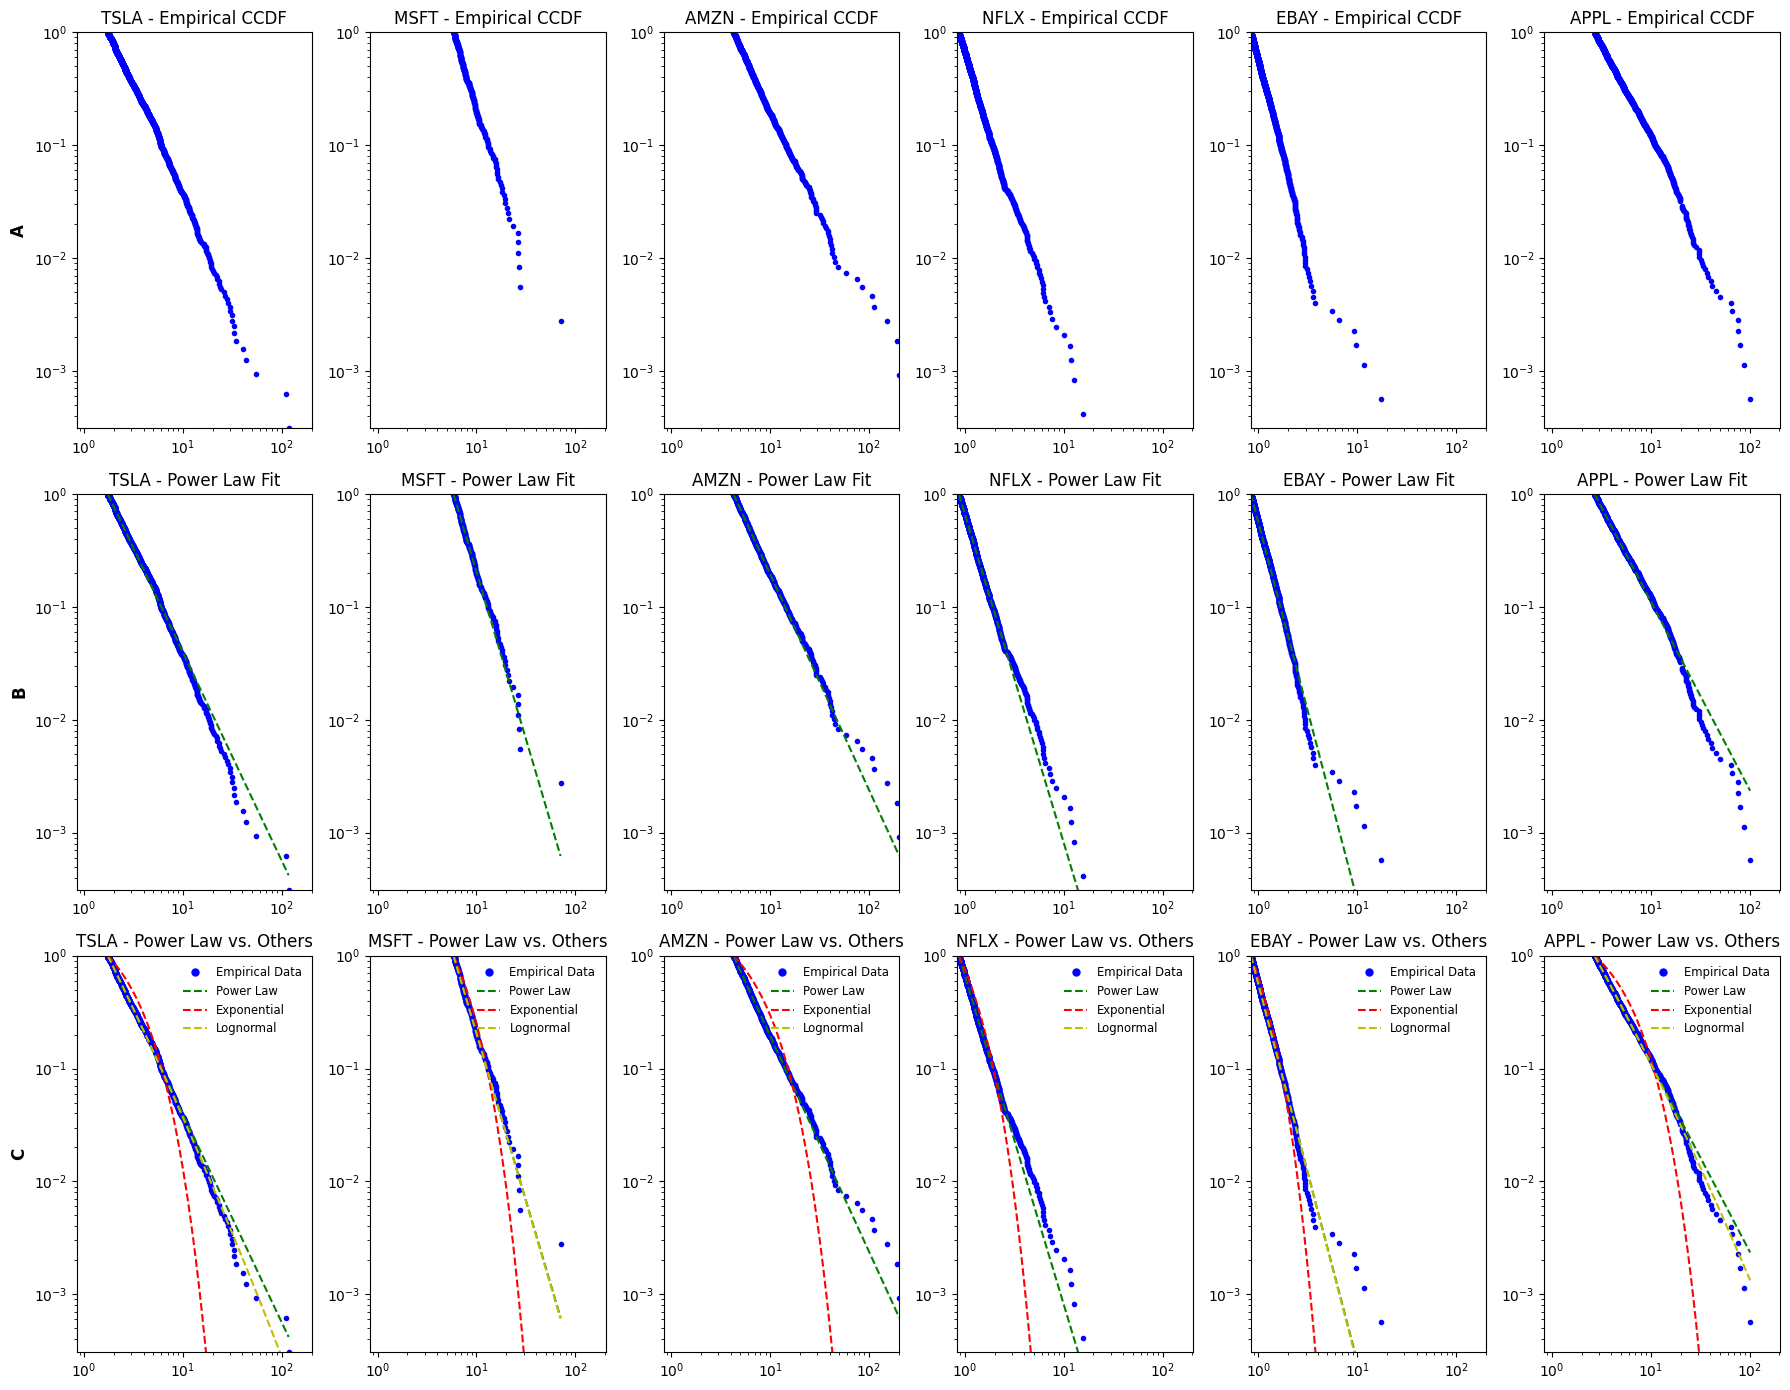

In [23]:
# Plot fitted objects
plot_fit_objects(volume_fit_objects)

#### 1.2.1 Retrieve Power law fitting results

In [24]:
# Get fitting parameters for specific distribution across all stocks
volume_fit_results = get_fitting_params(volume_fit_objects, 'power_law')
print(volume_fit_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  2.846735  1.738285     0.019358
1  MSFT    power_law  3.961718  5.852435     0.030002
2  AMZN    power_law  2.911698  4.257636     0.015945
3  NFLX    power_law  3.912460  0.871134     0.018644
4  EBAY    power_law  4.342729  0.840770     0.011462
5  APPL    power_law  2.669783  2.694047     0.014901


In [25]:
# Average Alpha exponents across stocks
min_alpha = volume_fit_results['alpha'].min()
max_alpha = volume_fit_results['alpha'].max()
avg_alpha = volume_fit_results['alpha'].mean()
std_dev_alpha = volume_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 2.6697832122816263
Max Alpha: 4.342729212299044
Average Alpha: 3.4408539386343384
std_dev_alpha: 0.711986634992309


#### 1.2.2. Compare alternative distributions

In [26]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volume_comparison = distribution_compare(volume_fit_objects, 'exponential')
display(volume_comparison)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,0.526504,1.738285,2.846735,0.019358,0.167579,6.296735,3.039798e-10
1,MSFT,exponential,0.334284,5.852435,3.961718,0.030002,0.125415,2.072804,3.819052e-02
2,AMZN,exponential,0.210635,4.257636,2.911698,0.015945,0.191489,4.608068,4.064280e-06
3,NFLX,exponential,2.136225,0.871134,3.912460,0.018644,0.113653,6.120420,9.332896e-10
4,EBAY,exponential,2.746977,0.840770,4.342729,0.011462,0.097098,2.815093,4.876317e-03
5,APPL,exponential,0.287961,2.694047,2.669783,0.014901,0.176446,6.795524,1.079193e-11


## 2. Signed Ordeflow Imbalance

In [18]:
# Aggregate orderflow
tsla_aggregate_orderflow = get_agg_features(tsla_raw_df, [T], remove_outliers=False)
msft_aggregate_orderflow = get_agg_features(msft_raw_df, [T], remove_outliers=False)
amzn_aggregate_orderflow = get_agg_features(amzn_raw_df, [T], remove_outliers=False)
nflx_aggregate_orderflow = get_agg_features(nflx_raw_df, [T],remove_outliers=False)
ebay_aggregate_orderflow = get_agg_features(ebay_raw_df, [T], remove_outliers=False)
appl_aggregate_orderflow = get_agg_features(appl_raw_df, [T],remove_outliers=False)

# Order Sign imbalance
sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'],
  'MSFT': msft_aggregate_orderflow['sign_imbalance'],
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'],
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'],
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'],
  'APPL': appl_aggregate_orderflow['sign_imbalance']
}

# Sign Volume Imbalance
volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['vol_imbalance'],
 'MSFT': msft_aggregate_orderflow['vol_imbalance'],
 'AMZN': amzn_aggregate_orderflow['vol_imbalance'],
 'NFLX': nflx_aggregate_orderflow['vol_imbalance'],
 'EBAY': ebay_aggregate_orderflow['vol_imbalance'],
 'APPL': appl_aggregate_orderflow['vol_imbalance']
}

### Stationarity Tests

In [19]:
# sign_imbalance ADF test
print('Order-sign Imbalance')
for stock, data in sign_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)
print('\n')


Order-sign Imbalance
TSLA
ADF: -11.33
p-value: 0.00,
N: 7552, 
critical values: {'1%': -3.431216197578816, '5%': -2.861922794140392, '10%': -2.5669737568795616}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -15.03
p-value: 0.00,
N: 15247, 
critical values: {'1%': -3.4307789631586263, '5%': -2.8617295833846796, '10%': -2.5668709106206444}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -18.18
p-value: 0.00,
N: 10140, 
critical values: {'1%': -3.4309950647136693, '5%': -2.8618250806650556, '10%': -2.5669217432960254}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -15.57
p-value: 0.00,
N: 16290, 
critical values: {'1%': -3.4307514936002126, '5%': -2.861717443834558, '10%': -2.566864448891165}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to b

In [20]:
# volume_imbalance ADF test
print('Signed-volume Imbalance')
for stock, data in volume_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

Signed-volume Imbalance
TSLA
ADF: -14.59
p-value: 0.00,
N: 7556, 
critical values: {'1%': -3.4312157388746796, '5%': -2.8619225914572133, '10%': -2.566973648988558}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -18.95
p-value: 0.00,
N: 15263, 
critical values: {'1%': -3.4307785134065885, '5%': -2.8617293846278415, '10%': -2.566870804824729}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -15.04
p-value: 0.00,
N: 10129, 
critical values: {'1%': -3.4309957654256156, '5%': -2.861825390304864, '10%': -2.566921908117538}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -18.28
p-value: 0.00,
N: 16289, 
critical values: {'1%': -3.430751518252241, '5%': -2.861717454729015, '10%': -2.5668644546901382}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to 

### 2.1. Order Sign Imbalance

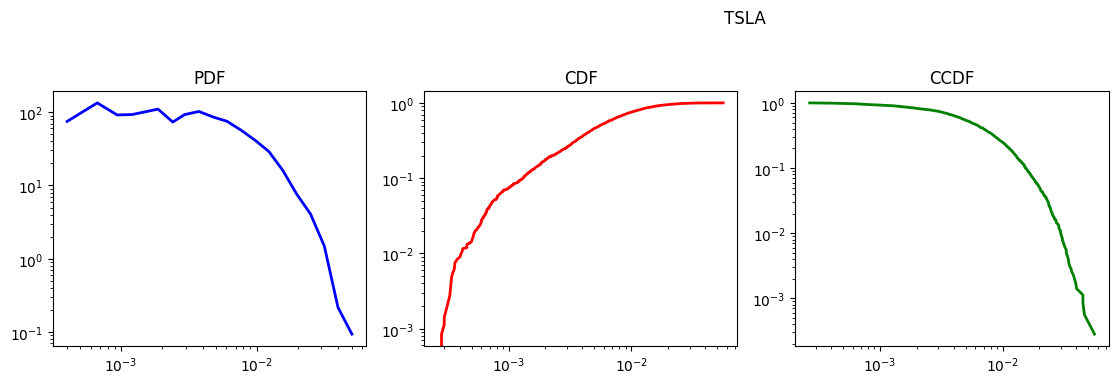

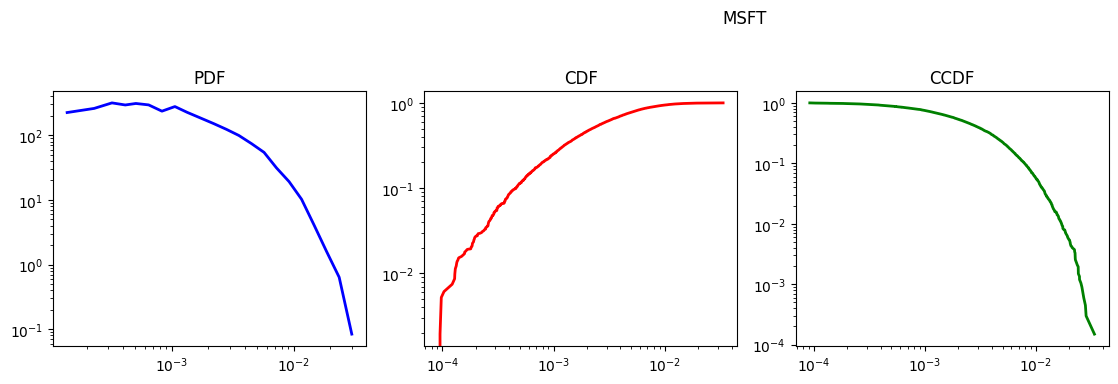

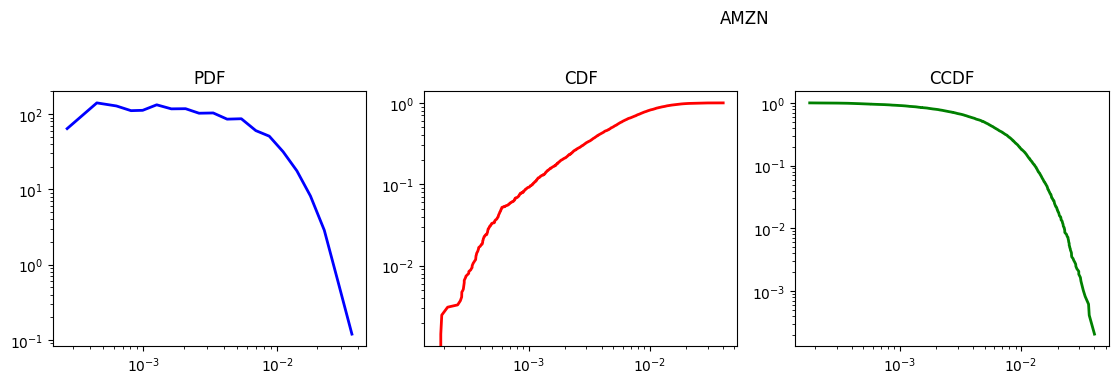

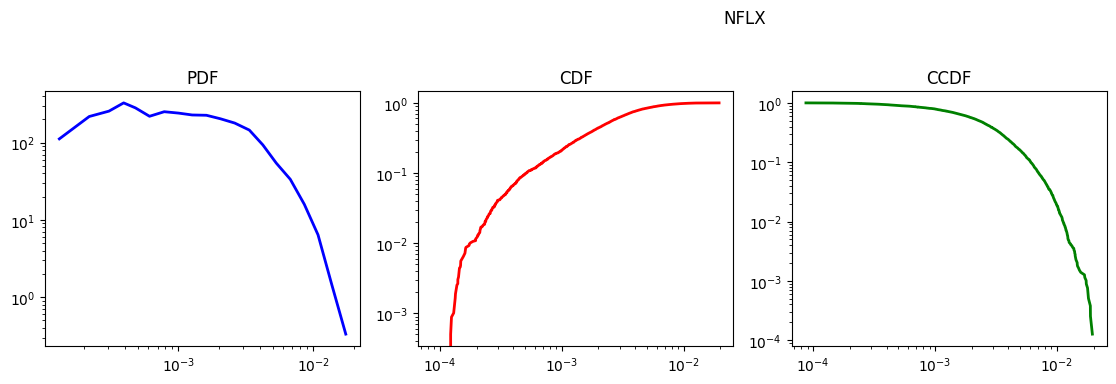

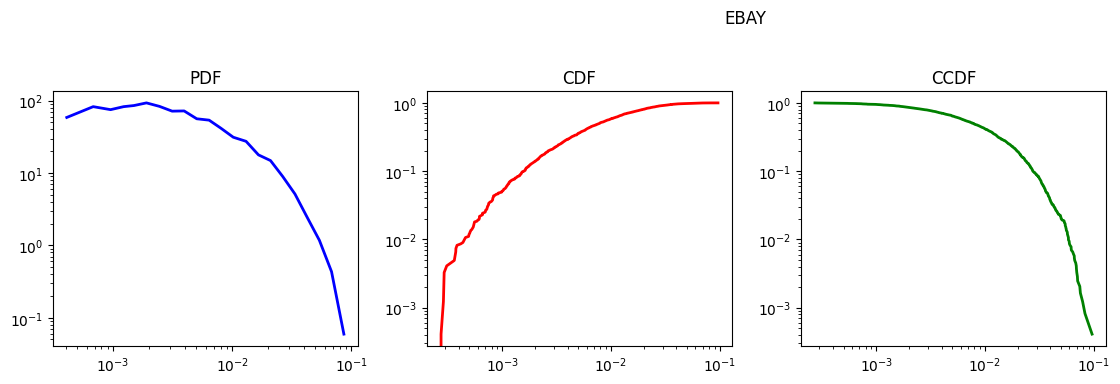

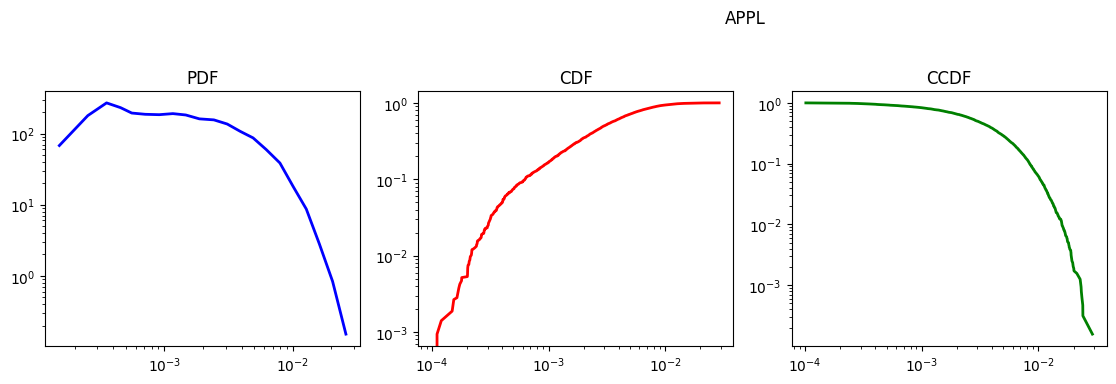

In [21]:
# Plot distribution of sign_imbalance for each stock
for stock_name, data in sign_imbalance.items():
    plot_distributions(stock_name, data)

#### 2.1.1. Fit power law distribution

In [22]:
# 1. Fit Powerlaw and retrieve fitted object/ results
sign_imbalance_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_sign_imbalance_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(sign_imbalance_data):
    sign_imbalance_fit_objects = fit_powerlaw(sign_imbalance, sign_imbalance_data)
else:
    sign_imbalance_fit_objects = load_fit_objects(sign_imbalance_data)

sign_imbalance_fit_objects

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


{'TSLA': <powerlaw.Fit at 0x2979d4150>,
 'MSFT': <powerlaw.Fit at 0x2961bf110>,
 'AMZN': <powerlaw.Fit at 0x29593d7d0>,
 'NFLX': <powerlaw.Fit at 0x297972810>,
 'EBAY': <powerlaw.Fit at 0x1775d5010>,
 'APPL': <powerlaw.Fit at 0x177510d10>}

In [21]:
# Plot fitted objects
plot_fit_objects(sign_imbalance_fit_objects)

NameError: name 'sign_imbalance_fit_objects' is not defined

#### 2.1.2. Retrieve Power law fitting results

In [24]:
# Get fitting parameters for specific distribution across all stocks
sign_imbalance_fit_results = get_fitting_params(sign_imbalance_fit_objects, 'power_law')
print(sign_imbalance_fit_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  7.770483  0.028571     0.046473
1  MSFT    power_law  4.561284  0.010479     0.052605
2  AMZN    power_law  4.833541  0.012812     0.061529
3  NFLX    power_law  7.105205  0.010106     0.042147
4  EBAY    power_law  4.218526  0.030334     0.054164
5  APPL    power_law  5.359118  0.010794     0.050624


In [25]:
# Average Alpha exponents across stocks
min_alpha = sign_imbalance_fit_results['alpha'].min()
max_alpha = sign_imbalance_fit_results['alpha'].max()
avg_alpha = sign_imbalance_fit_results['alpha'].mean()
std_dev_alpha = sign_imbalance_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 4.218526081451033
Max Alpha: 7.7704829977931995
Average Alpha: 5.641359386405543
std_dev_alpha: 1.4559712507352809


#### 2.1.3. Compare alternative distributions

In [26]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
sign_imbalance_comparison = distribution_compare(sign_imbalance_fit_objects, 'exponential')
display(sign_imbalance_comparison)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,202.719187,0.028571,7.770483,0.046473,0.053800,0.484972,0.627696
1,MSFT,exponential,260.708010,0.010479,4.561284,0.052605,0.041140,-1.670737,0.094774
2,AMZN,exponential,236.253201,0.012812,4.833541,0.061529,0.019998,-3.364393,0.000767
3,NFLX,exponential,512.206706,0.010106,7.105205,0.042147,0.061623,0.133357,0.893911
4,EBAY,exponential,79.995786,0.030334,4.218526,0.054164,0.058655,-2.363414,0.018107
5,APPL,exponential,327.544583,0.010794,5.359118,0.050624,0.037819,-2.503812,0.012286


### 2.2. Volume Imbalance

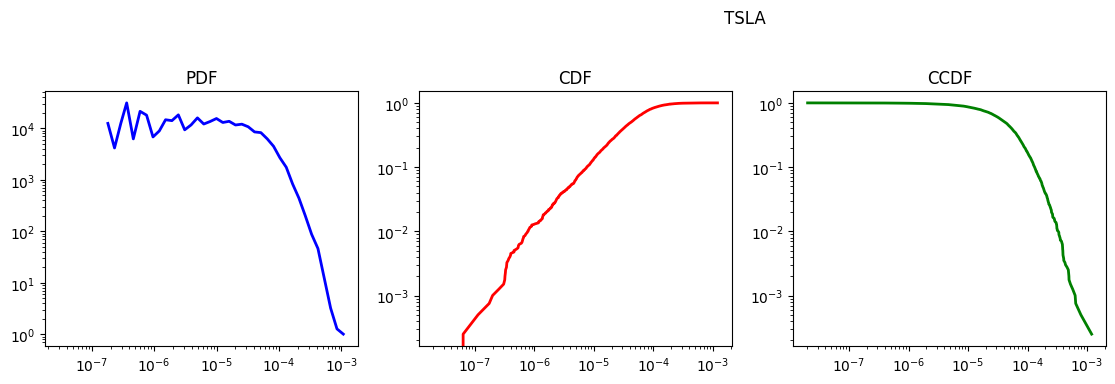

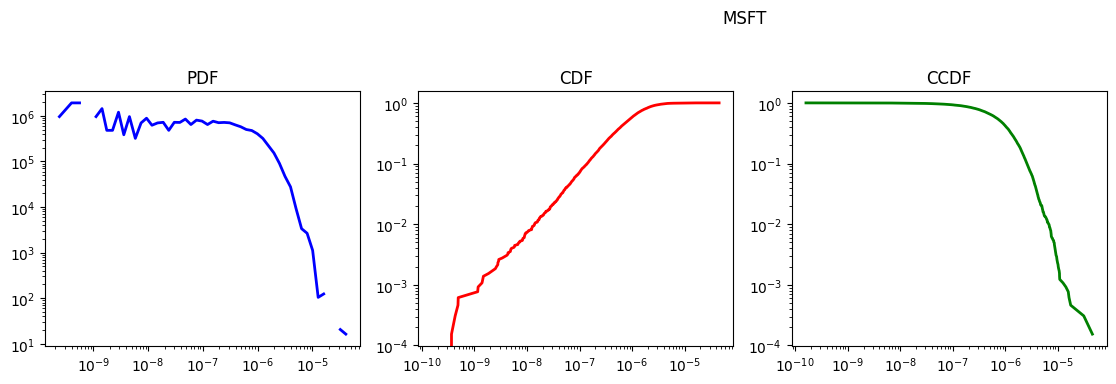

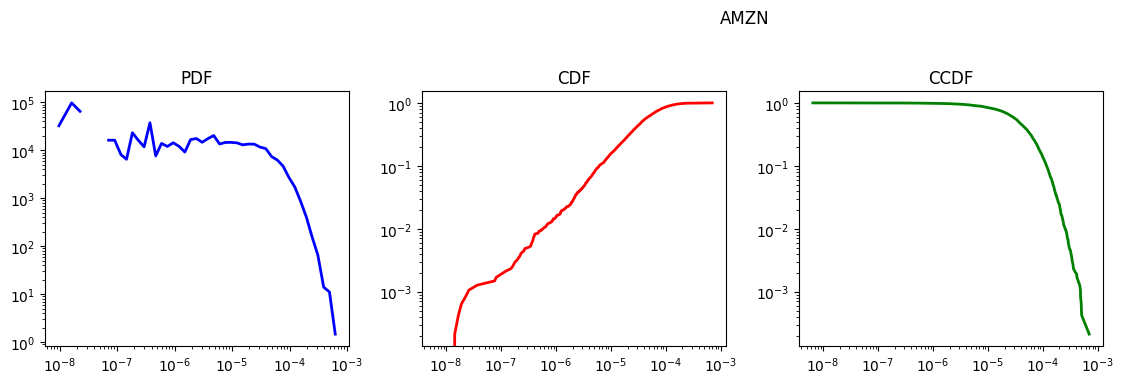

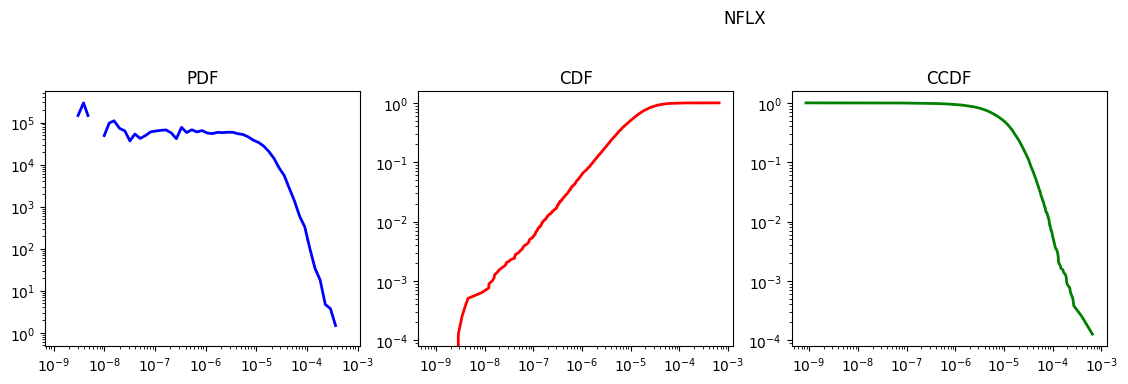

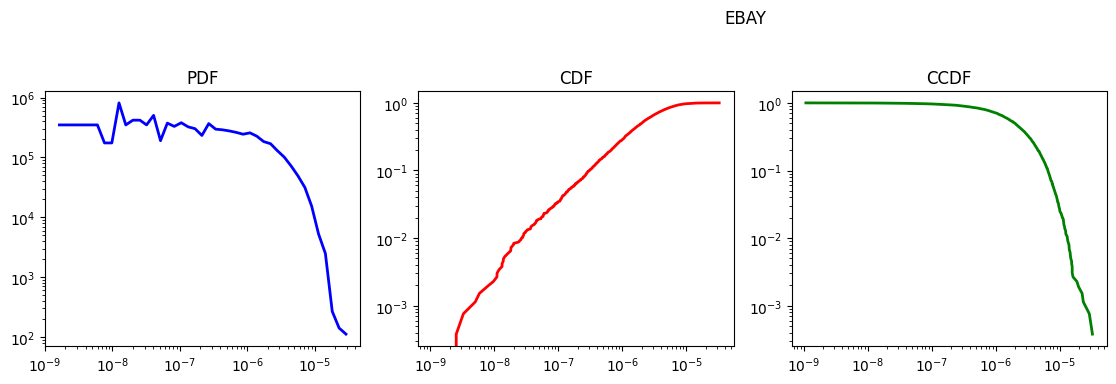

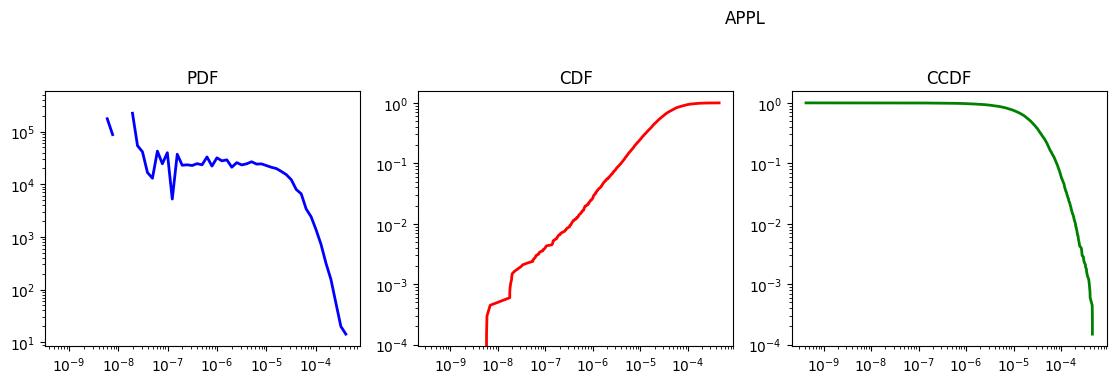

In [27]:
# Plot distribution of volume_imbalance for each stock
for stock_name, data in volume_imbalance.items():
    plot_distributions(stock_name, data)

#### 2.2.1. Fit power law distribution

In [28]:
# 1. Fit Powerlaw and retrieve fitted object/ results
volume_imbalance_data = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'distributions', 'mo_volume_imbalance_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(volume_imbalance_data):
    volume_imbalance_data_fit_objects = fit_powerlaw(volume_imbalance, volume_imbalance_data)
else:
    volume_imbalance_data_fit_objects = load_fit_objects(volume_imbalance_data)

volume_imbalance_data_fit_objects

Calculating best minimal value for power law fit


/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1151: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x2fcdac410>,
 'MSFT': <powerlaw.Fit at 0x177b7d150>,
 'AMZN': <powerlaw.Fit at 0x2ee6f2790>,
 'NFLX': <powerlaw.Fit at 0x177f89450>,
 'EBAY': <powerlaw.Fit at 0x177f8aa50>,
 'APPL': <powerlaw.Fit at 0x295a72810>}

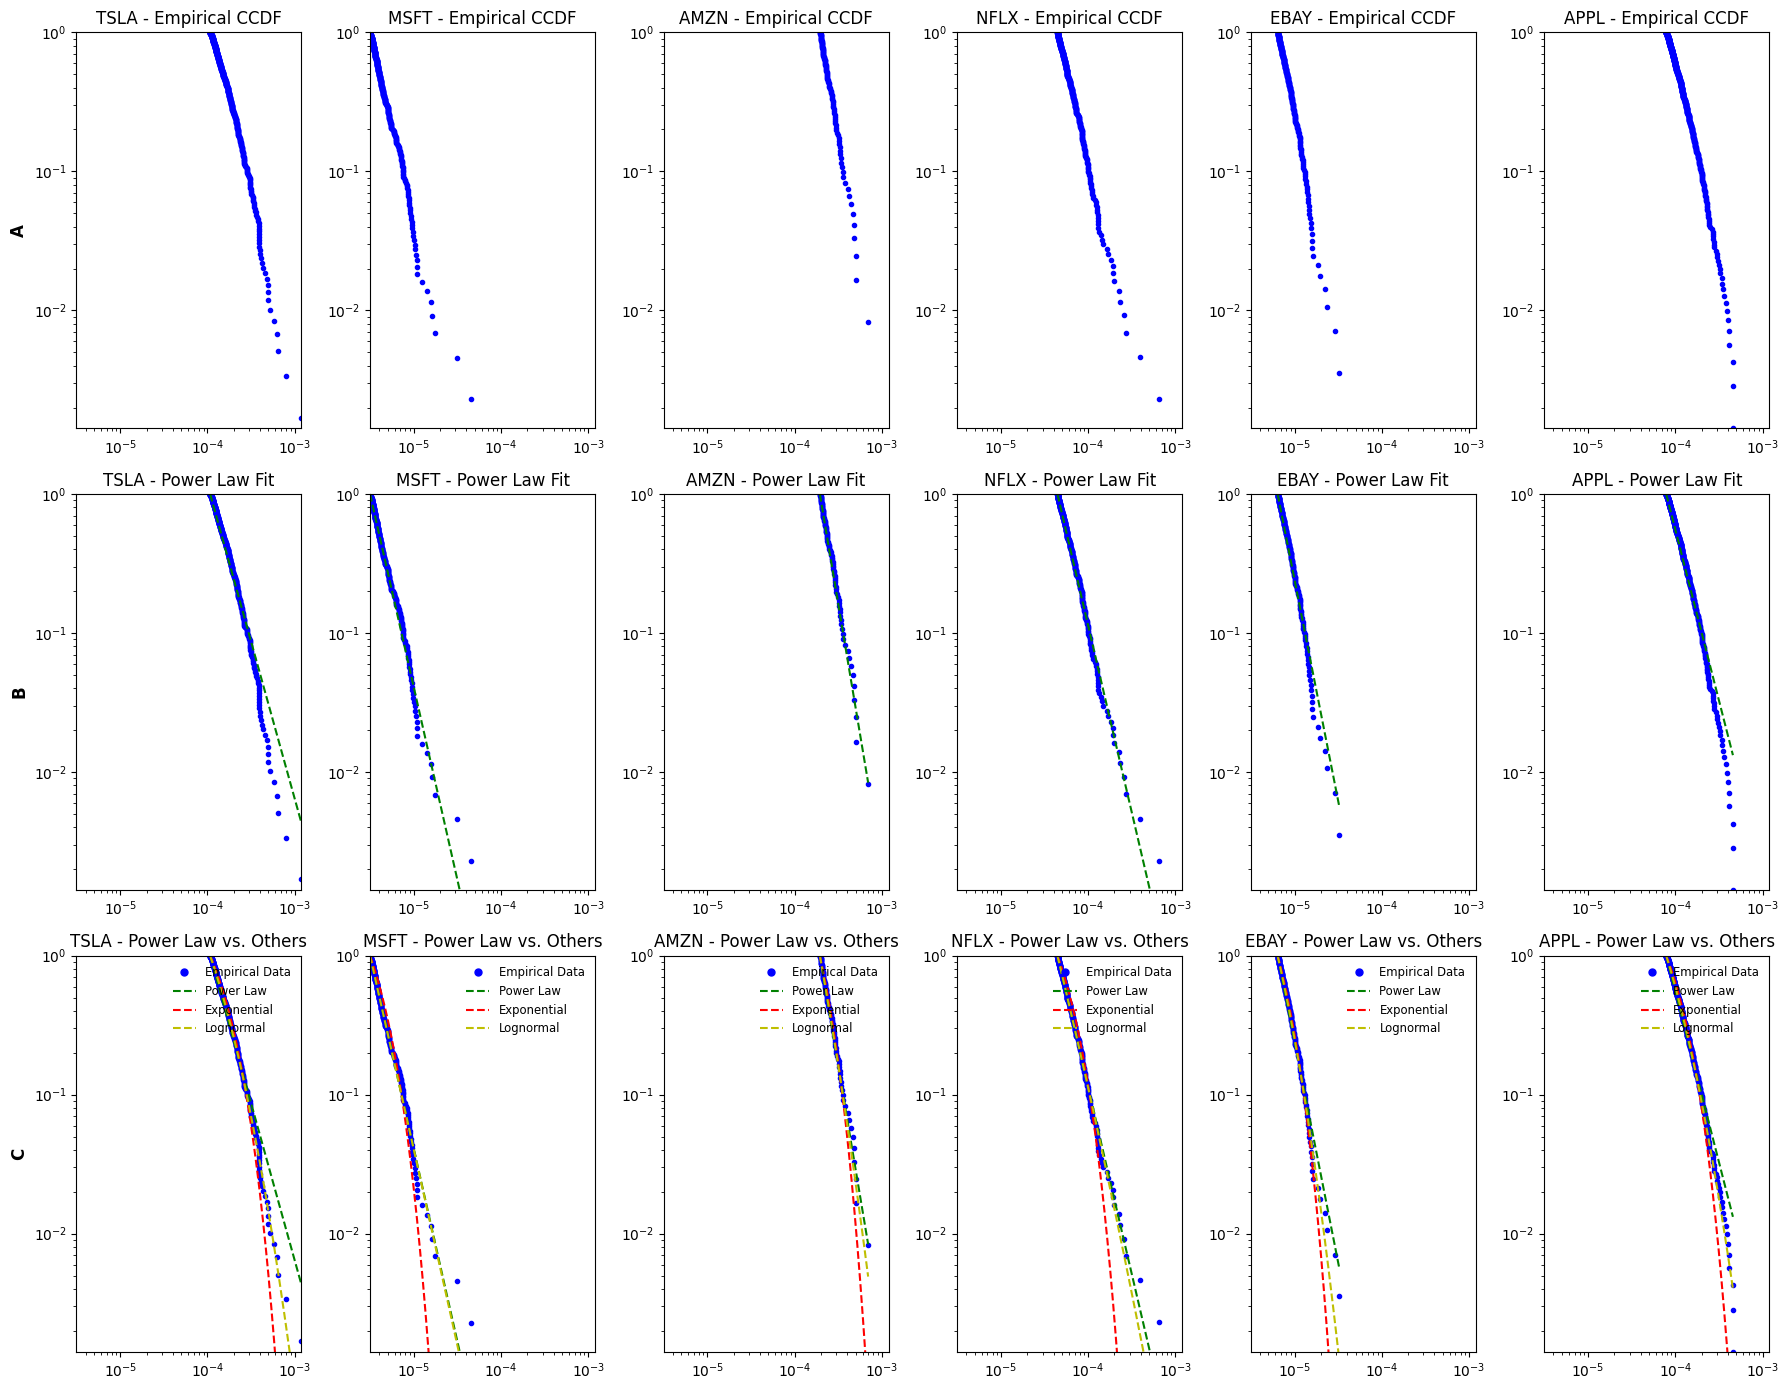

In [29]:
# Plot fitted objects
plot_fit_objects(volume_imbalance_data_fit_objects)

#### 2.2.2. Retrieve Power law fitting results

In [30]:
# Get fitting parameters for specific distribution across all stocks
volume_imbalance_fit_results = get_fitting_params(volume_imbalance_data_fit_objects, 'power_law')
print(volume_imbalance_fit_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  3.260552  0.000107     0.047343
1  MSFT    power_law  3.771222  0.000003     0.029307
2  AMZN    power_law  4.750468  0.000195     0.045448
3  NFLX    power_law  3.686526  0.000044     0.025103
4  EBAY    power_law  4.179667  0.000006     0.048141
5  APPL    power_law  3.456765  0.000079     0.046415


In [31]:
# Average Alpha exponents across stocks
min_alpha = volume_imbalance_fit_results['alpha'].min()
max_alpha = volume_imbalance_fit_results['alpha'].max()
avg_alpha = volume_imbalance_fit_results['alpha'].mean()
std_dev_alpha = volume_imbalance_fit_results['alpha'].std()

print(f"Min Alpha: {min_alpha}")
print(f"Max Alpha: {max_alpha}")
print(f"Average Alpha: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alpha: 3.260551770632118
Max Alpha: 4.750467774571268
Average Alpha: 3.8508666411901284
std_dev_alpha: 0.5393572075395177


#### 2.2.3. Compare alternative distributions

In [32]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volume_imbalance_comparison = distribution_compare(volume_imbalance_data_fit_objects, 'exponential')
display(volume_imbalance_comparison)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,13486.887523,0.000107,3.260552,0.047343,0.071000,0.248695,0.803597
1,MSFT,exponential,565314.932841,0.000003,3.771222,0.029307,0.129589,2.098662,0.035847
2,AMZN,exponential,14581.344889,0.000195,4.750468,0.045448,0.086580,0.618205,0.536440
3,NFLX,exponential,38769.406330,0.000044,3.686526,0.025103,0.106802,1.897879,0.057712
4,EBAY,exponential,362349.270214,0.000006,4.179667,0.048141,0.052249,0.140584,0.888198
5,APPL,exponential,20728.301345,0.000079,3.456765,0.046415,0.070010,0.344234,0.730670
